In [1]:
# Importing Necessary Libraries
import numpy as np
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector, Operator, DensityMatrix, ScalarOp
from qiskit import QuantumCircuit, QuantumRegister, assemble, Aer, transpile
from qiskit.tools.jupyter import *
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

In [2]:
n = 5 # Number of variables in Boolean statement

In [3]:
# Problem Boolean Function
def Query(bi):
    K = []
    for i in range(len(bi)):
        K.append(int(bi[i]))
    [a,b,c,d,e] = K
    
    fn = ((not c or (d and (not e)))and a and b) # Enter the Boolean Formulation here
    
    if fn==True:
        return 1.0
    else:
        return 0.0

In [4]:
# Function to generate a binary list
def bin_list(n):
    ans = ['0','1']
    for i in range(n-1):
        P1 = ['0' + ans[j] for j in range(0,2**(i+1))]
        P2 = ['1' + ans[j] for j in range(0,2**(i+1))]
        ans = P1 + P2
    return ans

In [5]:
# Generating Matrix for the Oracle Unitary
def matrix(n):
    # n = number of variables
    bi = bin_list(n)
    mat = np.eye(2**n)
    index = 0
    for i in bi:
        k = Query(i)
        if k==1.0:
            mat[index,index] = -1
        index+=1
    return mat

In [6]:
matrix(5)

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0., -1.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  1.]])

In [7]:
# Creating Oracle fn for the problem
def oracle(n):
    ora = QuantumCircuit(n, name = "Oracle")
    ora.unitary(matrix(n), [i for i in range(n)], label="Oracle")
    return ora

In [8]:
oracle(n).draw()

┌─────────┐
q_0: ┤0        ├
     │         │
q_1: ┤1        ├
     │         │
q_2: ┤2 Oracle ├
     │         │
q_3: ┤3        ├
     │         │
q_4: ┤4        ├
     └─────────┘

In [9]:
def diffuser(n):
    qc = QuantumCircuit(n, name="Diffuser")
    qubits = [i for i in range(n)]
    qc.h(qubits)
    qc.x(qubits)
    qc.barrier()
    qc.h(n-1)
    qc.mct(qubits[:n-1],n-1)
    qc.h(n-1)
    qc.barrier()
    qc.x(qubits)
    qc.h(qubits)
    return qc

In [10]:
diffuser(n).draw()

┌───┐┌───┐ ░                 ░ ┌───┐┌───┐
q_0: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░        │        ░ ├───┤├───┤
q_1: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░        │        ░ ├───┤├───┤
q_2: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░        │        ░ ├───┤├───┤
q_3: ┤ H ├┤ X ├─░────────■────────░─┤ X ├┤ H ├
     ├───┤├───┤ ░ ┌───┐┌─┴─┐┌───┐ ░ ├───┤├───┤
q_4: ┤ H ├┤ X ├─░─┤ H ├┤ X ├┤ H ├─░─┤ X ├┤ H ├
     └───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘

In [11]:
# Building the Quantum Circuit
qc = QuantumCircuit(n)
qubits = [i for i in range(n)]
steps = 2

qc.h(qubits)
for i in range(steps):
    qc.append(oracle(n),qubits)
    qc.append(diffuser(n),qubits)
qc.measure_all()
qc.draw()

┌───┐┌─────────┐┌───────────┐┌─────────┐┌───────────┐ ░ ┌─┐            
   q_0: ┤ H ├┤0        ├┤0          ├┤0        ├┤0          ├─░─┤M├────────────
        ├───┤│         ││           ││         ││           │ ░ └╥┘┌─┐         
   q_1: ┤ H ├┤1        ├┤1          ├┤1        ├┤1          ├─░──╫─┤M├─────────
        ├───┤│         ││           ││         ││           │ ░  ║ └╥┘┌─┐      
   q_2: ┤ H ├┤2 Oracle ├┤2 Diffuser ├┤2 Oracle ├┤2 Diffuser ├─░──╫──╫─┤M├──────
        ├───┤│         ││           ││         ││           │ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ H ├┤3        ├┤3          ├┤3        ├┤3          ├─░──╫──╫──╫─┤M├───
        ├───┤│         ││           ││         ││           │ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤ H ├┤4        ├┤4          ├┤4        ├┤4          ├─░──╫──╫──╫──╫─┤M├
        └───┘└─────────┘└───────────┘└─────────┘└───────────┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════════════════════════════════════════════════════╩══╩══╩══╩══╩═
                                                                 0  1  2  3  4

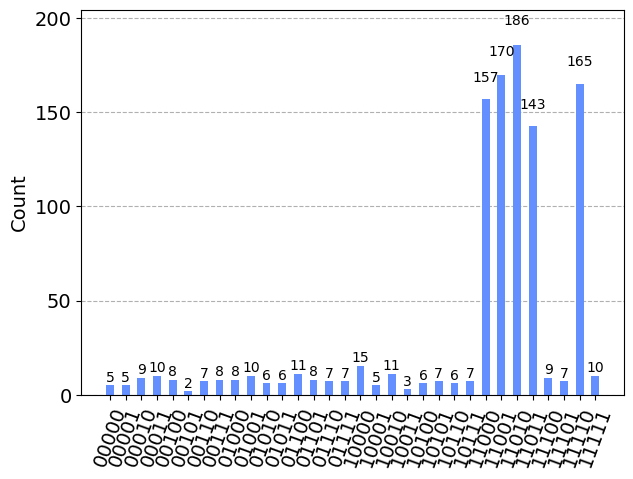

In [12]:
# Plotting the results
sim = Aer.get_backend('aer_simulator')
qc = transpile(qc, sim)
qobj = assemble(qc)
results = sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [13]:
# Extracting the Solutions
keys = list(counts.keys())
values = list(counts.values())
soln = []
for i in range(len(keys)):
    if values[i] >= 100:
        soln.append(keys[i])
print('The Solutions are : ',soln)

The Solutions are :  ['11110', '11001', '11010', '11011', '11000']
